# Testing Understanding of Tensorflow

### Following: https://www.tensorflow.org/tutorials/quickstart/advanced

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11493376/11490434 [==============================] - 1s 0us/step


In [6]:
x_train.shape

(60000, 28, 28, 1)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [8]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [11]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [12]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [15]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result(),
                        test_loss.result(),
                        test_accuracy.result()))

Epoch 1, Loss: 0.0028, Accuracy: 99.8983, Test Loss: 0.0853, Test Accuracy: 98.5400
Epoch 2, Loss: 0.0021, Accuracy: 99.9333, Test Loss: 0.0850, Test Accuracy: 98.5300
Epoch 3, Loss: 0.0036, Accuracy: 99.8633, Test Loss: 0.0884, Test Accuracy: 98.3700
Epoch 4, Loss: 0.0029, Accuracy: 99.8967, Test Loss: 0.0855, Test Accuracy: 98.5400
Epoch 5, Loss: 0.0021, Accuracy: 99.9283, Test Loss: 0.0919, Test Accuracy: 98.6000


# Linear Regression

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from matplotlib import rc

# The following is code to set defaults for Matplotlib graphs
rc('font',**{'family':'serif','weight':'light', 'size':20})
rc('text', usetex=False)
rc('ytick', labelsize = 15)
rc('xtick', labelsize = 15)
rc('figure', **{'titlesize':20, 'titleweight':'light', 'figsize':(15,8)})
rc('legend', **{'fontsize':20, 'frameon': False})
rc('axes', **{'labelsize':18, 
                'labelweight':'light', 
                'spines.top': 'False', 'spines.right':'False',
                'prop_cycle':  """cycler('color',['2476AB', 'EF9C34', 'D22C2C', 
                            'E5D81D', '8E44AD','1EB22C', '38C6BE','C638A2'])""",
                'titlesize': 25, 'titleweight': 'light'
    })

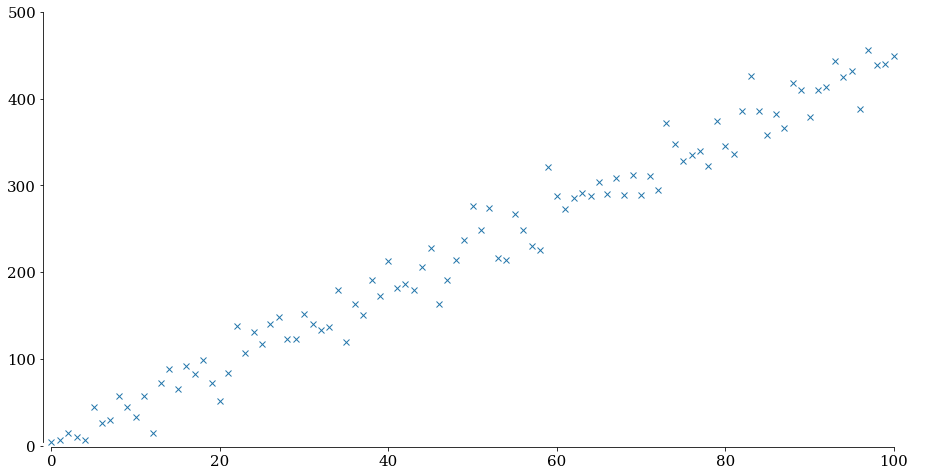

In [5]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100

X = np.linspace(0,100,101)

μ_real = 4.5

# Add a "jitter"
y_true = μ_real * X + np.random.normal(loc=0,scale = 20, size = len(X))

fig,ax = plt.subplots(figsize=(16,8))
plt.plot(X, y_true, marker= 'x', ls='')

ax.set_xlim(X.min()-(X.max() - X.min())/100)
ax.set_ylim(y_true.min()-(roundup(y_true.max() - y_true.min())/100), roundup(y_true.max()))

ax.spines['bottom'].set_bounds(X.min(), X.max())
ax.spines['left'].set_bounds(y_true.min(), roundup(y_true.max()))

In [6]:
# Frequentist approach
X_hat = np.array([[1 for i in range(len(X))], X]).T

μ_est_lin = np.linalg.inv(X_hat.T@X_hat) @ X_hat.T @ y_true

In [7]:
def line_reg(beta, x):
    return beta[1]*x[:,1] + beta[0]*x[:,0]

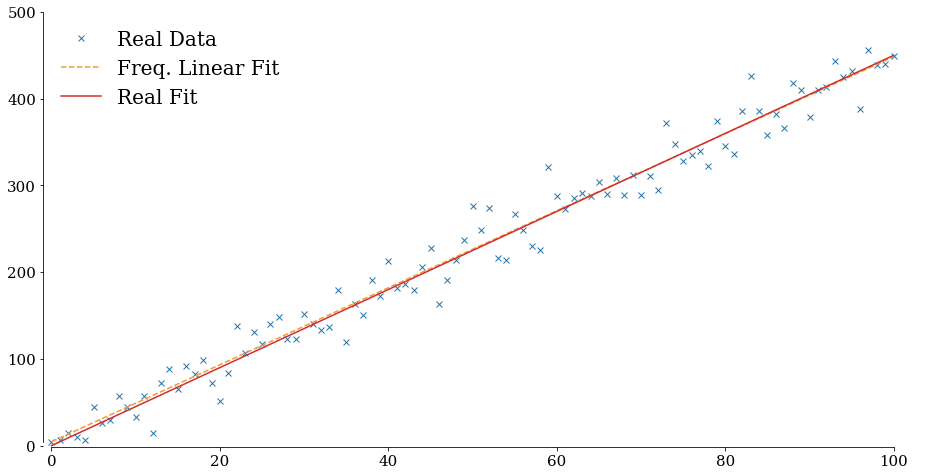

In [8]:
fig,ax = plt.subplots(figsize=(16,8))
plt.plot(X_hat[:,1], y_true, marker= 'x', ls='', label = 'Real Data')
plt.plot(X, line_reg(μ_est_lin, X_hat), ls='--', label = 'Freq. Linear Fit')
plt.plot(X, μ_real*X, label = 'Real Fit')

ax.set_xlim(X.min()-(X.max() - X.min())/100)
ax.set_ylim(y_true.min()-(roundup(y_true.max() - y_true.min())/100), roundup(y_true.max()))

ax.spines['bottom'].set_bounds(X.min(), X.max())
ax.spines['left'].set_bounds(y_true.min(), roundup(y_true.max()))

plt.legend()

## First principles

In [106]:
import tensorflow as tf

In [107]:
from tensorflow import keras

In [108]:
features = np.array(X, dtype = np.float32).reshape(-1,1)

In [109]:
target = np.array(y_true, dtype = np.float32)

In [110]:
intercept = tf.Variable(0., np.float32)
gradient = tf.Variable(1., np.float32)

In [119]:
def tf_model(gradient, intercept, features):
    return features * gradient + intercept

def tf_loss(gradient, intercept, features, y):
    y_pred = tf_model(gradient, intercept, features)
    
    return keras.losses.mse(y, y_pred)

In [120]:
opt = keras.optimizers.Adam()

In [121]:
n_steps = 10000
for j in range(n_steps):
    opt.minimize(lambda: tf_loss(gradient, intercept, features, target),
                var_list=[gradient, intercept],
                )
    
    if j % 100 == 0:
        print(f"Error: {tf_loss(gradient, intercept, features, target).numpy().mean():6.2f} ({j} of {n_steps})")

Error: 27099.74 (0 of 10000)
Error: 27089.59 (100 of 10000)
Error: 27079.57 (200 of 10000)
Error: 27069.56 (300 of 10000)
Error: 27059.56 (400 of 10000)
Error: 27049.56 (500 of 10000)
Error: 27039.57 (600 of 10000)
Error: 27029.57 (700 of 10000)
Error: 27019.61 (800 of 10000)
Error: 27009.65 (900 of 10000)
Error: 26999.69 (1000 of 10000)
Error: 26989.74 (1100 of 10000)
Error: 26979.80 (1200 of 10000)
Error: 26969.86 (1300 of 10000)
Error: 26959.92 (1400 of 10000)
Error: 26949.99 (1500 of 10000)
Error: 26940.07 (1600 of 10000)
Error: 26930.15 (1700 of 10000)
Error: 26920.23 (1800 of 10000)
Error: 26910.32 (1900 of 10000)
Error: 26900.43 (2000 of 10000)
Error: 26890.54 (2100 of 10000)
Error: 26880.67 (2200 of 10000)
Error: 26870.80 (2300 of 10000)
Error: 26860.94 (2400 of 10000)
Error: 26851.07 (2500 of 10000)
Error: 26841.22 (2600 of 10000)
Error: 26831.37 (2700 of 10000)
Error: 26821.52 (2800 of 10000)
Error: 26811.68 (2900 of 10000)
Error: 26801.84 (3000 of 10000)
Error: 26792.02 (310

Error: 24742.92 (25200 of 10000)
Error: 24734.20 (25300 of 10000)
Error: 24725.49 (25400 of 10000)
Error: 24716.79 (25500 of 10000)
Error: 24708.09 (25600 of 10000)
Error: 24699.40 (25700 of 10000)
Error: 24690.71 (25800 of 10000)
Error: 24682.03 (25900 of 10000)
Error: 24673.35 (26000 of 10000)
Error: 24664.68 (26100 of 10000)
Error: 24656.01 (26200 of 10000)
Error: 24647.34 (26300 of 10000)
Error: 24638.68 (26400 of 10000)
Error: 24630.04 (26500 of 10000)
Error: 24621.38 (26600 of 10000)
Error: 24612.74 (26700 of 10000)
Error: 24604.10 (26800 of 10000)
Error: 24595.47 (26900 of 10000)
Error: 24586.84 (27000 of 10000)
Error: 24578.22 (27100 of 10000)
Error: 24569.60 (27200 of 10000)
Error: 24560.99 (27300 of 10000)
Error: 24552.38 (27400 of 10000)
Error: 24543.78 (27500 of 10000)
Error: 24535.18 (27600 of 10000)
Error: 24526.59 (27700 of 10000)
Error: 24518.00 (27800 of 10000)
Error: 24509.42 (27900 of 10000)
Error: 24500.84 (28000 of 10000)
Error: 24492.27 (28100 of 10000)
Error: 244

Error: 22725.35 (50200 of 10000)
Error: 22717.92 (50300 of 10000)
Error: 22710.50 (50400 of 10000)
Error: 22703.08 (50500 of 10000)
Error: 22695.66 (50600 of 10000)
Error: 22688.26 (50700 of 10000)
Error: 22680.85 (50800 of 10000)
Error: 22673.45 (50900 of 10000)
Error: 22666.05 (51000 of 10000)
Error: 22658.66 (51100 of 10000)
Error: 22651.28 (51200 of 10000)
Error: 22643.90 (51300 of 10000)
Error: 22636.52 (51400 of 10000)
Error: 22629.15 (51500 of 10000)
Error: 22621.79 (51600 of 10000)
Error: 22614.42 (51700 of 10000)
Error: 22607.07 (51800 of 10000)
Error: 22599.72 (51900 of 10000)
Error: 22592.37 (52000 of 10000)
Error: 22585.03 (52100 of 10000)
Error: 22577.70 (52200 of 10000)
Error: 22570.37 (52300 of 10000)
Error: 22563.04 (52400 of 10000)
Error: 22555.72 (52500 of 10000)
Error: 22548.40 (52600 of 10000)
Error: 22541.10 (52700 of 10000)
Error: 22533.79 (52800 of 10000)
Error: 22526.49 (52900 of 10000)
Error: 22519.19 (53000 of 10000)
Error: 22511.90 (53100 of 10000)
Error: 225

Error: 21023.17 (75200 of 10000)
Error: 21016.98 (75300 of 10000)
Error: 21010.80 (75400 of 10000)
Error: 21004.63 (75500 of 10000)
Error: 20998.46 (75600 of 10000)
Error: 20992.30 (75700 of 10000)
Error: 20986.14 (75800 of 10000)
Error: 20979.99 (75900 of 10000)
Error: 20973.84 (76000 of 10000)
Error: 20967.70 (76100 of 10000)
Error: 20961.56 (76200 of 10000)
Error: 20955.43 (76300 of 10000)
Error: 20949.30 (76400 of 10000)
Error: 20943.18 (76500 of 10000)
Error: 20937.07 (76600 of 10000)
Error: 20930.95 (76700 of 10000)
Error: 20924.84 (76800 of 10000)
Error: 20918.74 (76900 of 10000)
Error: 20912.65 (77000 of 10000)
Error: 20906.55 (77100 of 10000)
Error: 20900.46 (77200 of 10000)
Error: 20894.38 (77300 of 10000)
Error: 20888.30 (77400 of 10000)
Error: 20882.23 (77500 of 10000)
Error: 20876.17 (77600 of 10000)
Error: 20870.10 (77700 of 10000)
Error: 20864.04 (77800 of 10000)
Error: 20857.99 (77900 of 10000)
Error: 20851.95 (78000 of 10000)
Error: 20845.90 (78100 of 10000)
Error: 208

In [123]:
## Functional API

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=128.16907>

In [45]:
inputs = keras.layers.Dense(3, activation='relu')(X.reshape(1,-1))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [48]:
# 1 feature, first layer has 3 neurons
w1 = tf.Variable(tf.random.normal([1,3]))
b1 = tf.Variable(tf.ones([3]))

# 2nd layer: 1 output, 3 input features
w2 = tf.Variable(tf.random.normal([3,1]))
b2 = tf.Variable([0.0])

In [57]:
def model(w1, b1, w2, b2, features):
    layer1 = keras.activations.relu(tf.matmul(features, w1)+b1)
    dropout1 = keras.layers.Dropout(0.25)(layer1)
    
    return keras.activations.relu(tf.matmul(dropout1, w2)+b2)

In [58]:
def loss_function(w1, b1, w2, b2, features, targets):
    prediction = model(w1, b1, w2, b2, features)
    
    return keras.losses.mse(targets, prediction)

In [65]:
n_steps = 10000

In [67]:
for j in range(n_steps):
    opt.minimize(lambda: loss_function(w1, b1, w2, b2, features, target), 
                 var_list=[w1, b1, w2, b2])
    if j % 100 == 0:
        print(f"Error: {(loss_function(w1, b1, w2, b2, features, target)).numpy().mean():6.2f} ({j} of {n_steps})")

Error: 17278.46 (0 of 10000)
Error: 17262.43 (100 of 10000)
Error: 17248.75 (200 of 10000)
Error: 17237.22 (300 of 10000)
Error: 17227.60 (400 of 10000)
Error: 17219.67 (500 of 10000)
Error: 17213.21 (600 of 10000)
Error: 17208.02 (700 of 10000)
Error: 17203.91 (800 of 10000)
Error: 17200.70 (900 of 10000)
Error: 17198.24 (1000 of 10000)
Error: 17196.38 (1100 of 10000)
Error: 17195.01 (1200 of 10000)
Error: 17194.01 (1300 of 10000)
Error: 17193.29 (1400 of 10000)
Error: 17192.80 (1500 of 10000)
Error: 17192.46 (1600 of 10000)
Error: 17192.23 (1700 of 10000)
Error: 17192.09 (1800 of 10000)
Error: 17191.99 (1900 of 10000)
Error: 17191.93 (2000 of 10000)
Error: 17191.90 (2100 of 10000)
Error: 17191.88 (2200 of 10000)
Error: 17191.87 (2300 of 10000)
Error: 17191.87 (2400 of 10000)
Error: 17191.86 (2500 of 10000)
Error: 17191.86 (2600 of 10000)
Error: 17191.86 (2700 of 10000)
Error: 17191.86 (2800 of 10000)
Error: 17191.86 (2900 of 10000)
Error: 17191.86 (3000 of 10000)
Error: 17191.86 (310

In [68]:
prediction = model(w1, b1, w2, b2, features)

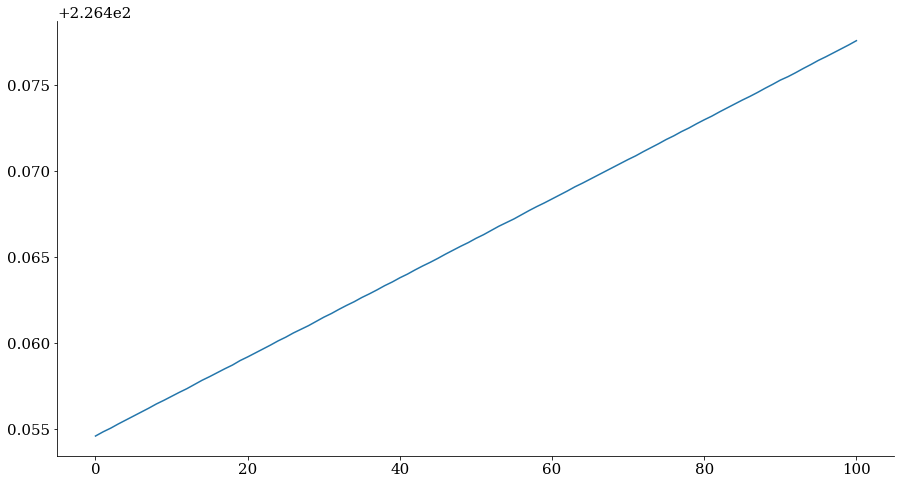

In [72]:
plt.plot(features, prediction.numpy())

In [71]:
prediction.numpy()

array([[226.45462],
       [226.45486],
       [226.45508],
       [226.45532],
       [226.45555],
       [226.45578],
       [226.45601],
       [226.45624],
       [226.45648],
       [226.4567 ],
       [226.45692],
       [226.45715],
       [226.45737],
       [226.45761],
       [226.45786],
       [226.45807],
       [226.4583 ],
       [226.45853],
       [226.45874],
       [226.459  ],
       [226.45921],
       [226.45944],
       [226.45967],
       [226.4599 ],
       [226.46014],
       [226.46036],
       [226.4606 ],
       [226.46082],
       [226.46103],
       [226.46127],
       [226.46152],
       [226.46173],
       [226.46198],
       [226.4622 ],
       [226.46242],
       [226.46266],
       [226.46288],
       [226.4631 ],
       [226.46335],
       [226.46356],
       [226.4638 ],
       [226.46402],
       [226.46426],
       [226.4645 ],
       [226.4647 ],
       [226.46494],
       [226.46518],
       [226.46541],
       [226.46564],
       [226.46585],


## Functional API with NN

In [166]:
input_layer = keras.Input(shape=(1,))

In [167]:
output_layer = keras.layers.Dense(1, activation = 'linear')(input_layer)

In [168]:
s_model = keras.Model(input_layer, output_layer)

In [172]:
s_model.compile(optimizer='adam', loss='mse')

In [173]:
s_model.fit(X, y_true, epochs = 1000)

Train on 101 samples
Epoch 1/1000
101/101 [==============================] - 0s 1ms/sample - loss: 1101.9066
Epoch 2/1000
101/101 [==============================] - 0s 38us/sample - loss: 1090.2745
Epoch 3/1000
101/101 [==============================] - 0s 36us/sample - loss: 1078.0135
Epoch 4/1000
101/101 [==============================] - 0s 38us/sample - loss: 1066.2150
Epoch 5/1000
101/101 [==============================] - 0s 39us/sample - loss: 1054.8233
Epoch 6/1000
101/101 [==============================] - 0s 109us/sample - loss: 1043.7499
Epoch 7/1000
101/101 [==============================] - 0s 69us/sample - loss: 1032.6896
Epoch 8/1000
101/101 [==============================] - 0s 59us/sample - loss: 1021.8997
Epoch 9/1000
101/101 [==============================] - 0s 55us/sample - loss: 1011.4844
Epoch 10/1000
101/101 [==============================] - 0s 43us/sample - loss: 1001.0755
Epoch 11/1000
101/101 [==============================] - 0s 42us/sample - loss: 989.8089

101/101 [==============================] - 0s 47us/sample - loss: 528.3128
Epoch 93/1000
101/101 [==============================] - 0s 42us/sample - loss: 526.5946
Epoch 94/1000
101/101 [==============================] - 0s 39us/sample - loss: 524.4316
Epoch 95/1000
101/101 [==============================] - 0s 47us/sample - loss: 522.6741
Epoch 96/1000
101/101 [==============================] - 0s 45us/sample - loss: 520.6567
Epoch 97/1000
101/101 [==============================] - 0s 58us/sample - loss: 518.8172
Epoch 98/1000
101/101 [==============================] - 0s 38us/sample - loss: 516.7882
Epoch 99/1000
101/101 [==============================] - 0s 37us/sample - loss: 514.8130
Epoch 100/1000
101/101 [==============================] - 0s 68us/sample - loss: 512.4682
Epoch 101/1000
101/101 [==============================] - 0s 42us/sample - loss: 510.7714
Epoch 102/1000
101/101 [==============================] - 0s 40us/sample - loss: 508.7772
Epoch 103/1000
101/101 [========

101/101 [==============================] - 0s 53us/sample - loss: 443.0026
Epoch 184/1000
101/101 [==============================] - 0s 48us/sample - loss: 442.9651
Epoch 185/1000
101/101 [==============================] - 0s 79us/sample - loss: 442.8866
Epoch 186/1000
101/101 [==============================] - 0s 52us/sample - loss: 442.7121
Epoch 187/1000
101/101 [==============================] - 0s 40us/sample - loss: 442.5347
Epoch 188/1000
101/101 [==============================] - 0s 45us/sample - loss: 442.2575
Epoch 189/1000
101/101 [==============================] - 0s 48us/sample - loss: 442.0501
Epoch 190/1000
101/101 [==============================] - 0s 46us/sample - loss: 441.8340
Epoch 191/1000
101/101 [==============================] - 0s 43us/sample - loss: 441.6012
Epoch 192/1000
101/101 [==============================] - 0s 43us/sample - loss: 441.4005
Epoch 193/1000
101/101 [==============================] - 0s 49us/sample - loss: 441.0820
Epoch 194/1000
101/101 [=

101/101 [==============================] - 0s 38us/sample - loss: 437.5268
Epoch 275/1000
101/101 [==============================] - 0s 56us/sample - loss: 437.3716
Epoch 276/1000
101/101 [==============================] - 0s 49us/sample - loss: 437.3701
Epoch 277/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.3359
Epoch 278/1000
101/101 [==============================] - 0s 43us/sample - loss: 437.3096
Epoch 279/1000
101/101 [==============================] - 0s 49us/sample - loss: 437.2880
Epoch 280/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.2760
Epoch 281/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.2695
Epoch 282/1000
101/101 [==============================] - 0s 46us/sample - loss: 437.2485
Epoch 283/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.2207
Epoch 284/1000
101/101 [==============================] - 0s 34us/sample - loss: 437.2375
Epoch 285/1000
101/101 [=

101/101 [==============================] - 0s 48us/sample - loss: 437.1094
Epoch 366/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.0368
Epoch 367/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.0894
Epoch 368/1000
101/101 [==============================] - 0s 43us/sample - loss: 437.1107
Epoch 369/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.2119
Epoch 370/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1288
Epoch 371/1000
101/101 [==============================] - ETA: 0s - loss: 301.038 - 0s 47us/sample - loss: 437.1253
Epoch 372/1000
101/101 [==============================] - 0s 41us/sample - loss: 437.1772
Epoch 373/1000
101/101 [==============================] - 0s 52us/sample - loss: 437.0826
Epoch 374/1000
101/101 [==============================] - 0s 64us/sample - loss: 437.2106
Epoch 375/1000
101/101 [==============================] - 0s 44us/sample - loss: 437.1049

101/101 [==============================] - 0s 44us/sample - loss: 437.2310
Epoch 456/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.2294
Epoch 457/1000
101/101 [==============================] - 0s 33us/sample - loss: 437.2196
Epoch 458/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.1898
Epoch 459/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1664
Epoch 460/1000
101/101 [==============================] - 0s 44us/sample - loss: 437.1563
Epoch 461/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1725
Epoch 462/1000
101/101 [==============================] - 0s 52us/sample - loss: 437.2112
Epoch 463/1000
101/101 [==============================] - 0s 44us/sample - loss: 437.2050
Epoch 464/1000
101/101 [==============================] - 0s 34us/sample - loss: 437.2303
Epoch 465/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.2041
Epoch 466/1000
101/101 [=

101/101 [==============================] - 0s 42us/sample - loss: 437.0825
Epoch 547/1000
101/101 [==============================] - 0s 57us/sample - loss: 437.1564
Epoch 548/1000
101/101 [==============================] - 0s 46us/sample - loss: 437.1498
Epoch 549/1000
101/101 [==============================] - 0s 45us/sample - loss: 437.1733
Epoch 550/1000
101/101 [==============================] - 0s 38us/sample - loss: 437.2670
Epoch 551/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.2065
Epoch 552/1000
101/101 [==============================] - 0s 45us/sample - loss: 437.2466
Epoch 553/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.1855
Epoch 554/1000
101/101 [==============================] - 0s 34us/sample - loss: 437.2263
Epoch 555/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.1550
Epoch 556/1000
101/101 [==============================] - 0s 48us/sample - loss: 437.1578
Epoch 557/1000
101/101 [=

101/101 [==============================] - 0s 35us/sample - loss: 437.2867
Epoch 638/1000
101/101 [==============================] - 0s 49us/sample - loss: 437.3297
Epoch 639/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.3216
Epoch 640/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.3568
Epoch 641/1000
101/101 [==============================] - 0s 47us/sample - loss: 437.3504
Epoch 642/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.3225
Epoch 643/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.4682
Epoch 644/1000
101/101 [==============================] - 0s 44us/sample - loss: 437.4607
Epoch 645/1000
101/101 [==============================] - 0s 38us/sample - loss: 437.4454
Epoch 646/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.4347
Epoch 647/1000
101/101 [==============================] - 0s 43us/sample - loss: 437.4168
Epoch 648/1000
101/101 [=

101/101 [==============================] - 0s 44us/sample - loss: 437.2912
Epoch 729/1000
101/101 [==============================] - 0s 38us/sample - loss: 437.1970
Epoch 730/1000
101/101 [==============================] - 0s 46us/sample - loss: 437.2035
Epoch 731/1000
101/101 [==============================] - 0s 48us/sample - loss: 437.2613
Epoch 732/1000
101/101 [==============================] - 0s 49us/sample - loss: 437.2897
Epoch 733/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.2537
Epoch 734/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.2941
Epoch 735/1000
101/101 [==============================] - 0s 38us/sample - loss: 437.2719
Epoch 736/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.2384
Epoch 737/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.2593
Epoch 738/1000
101/101 [==============================] - 0s 43us/sample - loss: 437.2571
Epoch 739/1000
101/101 [=

101/101 [==============================] - 0s 45us/sample - loss: 437.2430
Epoch 820/1000
101/101 [==============================] - 0s 55us/sample - loss: 437.2310
Epoch 821/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.1906
Epoch 822/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.0527
Epoch 823/1000
101/101 [==============================] - 0s 45us/sample - loss: 437.2178
Epoch 824/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1539
Epoch 825/1000
101/101 [==============================] - 0s 35us/sample - loss: 437.0481
Epoch 826/1000
101/101 [==============================] - 0s 50us/sample - loss: 436.9496
Epoch 827/1000
101/101 [==============================] - 0s 41us/sample - loss: 437.1532
Epoch 828/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.0881
Epoch 829/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.1386
Epoch 830/1000
101/101 [=

101/101 [==============================] - 0s 35us/sample - loss: 437.1187
Epoch 911/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1700
Epoch 912/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1094
Epoch 913/1000
101/101 [==============================] - 0s 35us/sample - loss: 437.1906
Epoch 914/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1154
Epoch 915/1000
101/101 [==============================] - 0s 58us/sample - loss: 437.0466
Epoch 916/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1041
Epoch 917/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.0939
Epoch 918/1000
101/101 [==============================] - 0s 41us/sample - loss: 437.1033
Epoch 919/1000
101/101 [==============================] - 0s 38us/sample - loss: 437.1028
Epoch 920/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.0865
Epoch 921/1000
101/101 [=

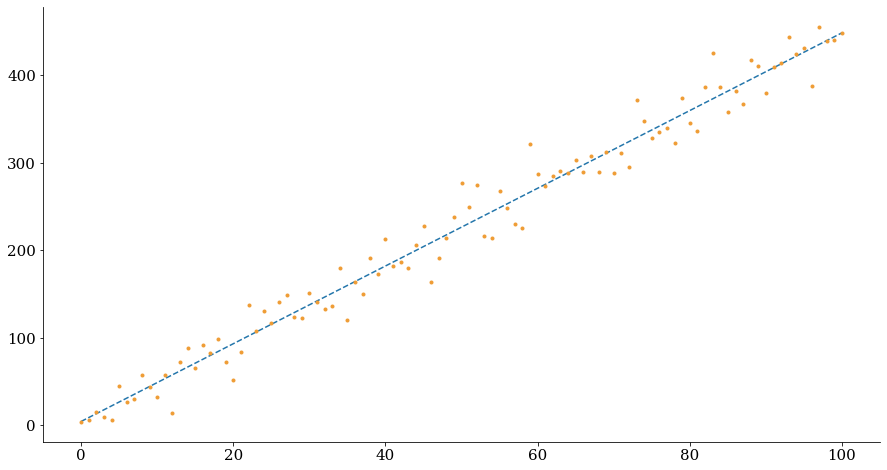

In [174]:
plt.plot(X, s_model.predict(X), ls = '--')
plt.plot(X, y_true, ls='', marker='.')

## Sequential API

In [208]:
model_s = keras.Sequential()

In [209]:
model_s.add(keras.layers.Dense(units=1,input_shape=(1,)))

In [210]:
model_s.add(keras.layers.Dense(1, activation='linear'))

In [211]:
model_s.compile(optimizer='adam', loss='mse')

In [212]:
model_s.fit(X, y_true, epochs = 1000)

Train on 101 samples
Epoch 1/1000
101/101 [==============================] - 0s 2ms/sample - loss: 58913.1087
Epoch 2/1000
101/101 [==============================] - 0s 42us/sample - loss: 58757.7634
Epoch 3/1000
101/101 [==============================] - 0s 38us/sample - loss: 58599.2138
Epoch 4/1000
101/101 [==============================] - 0s 37us/sample - loss: 58444.2470
Epoch 5/1000
101/101 [==============================] - 0s 45us/sample - loss: 58277.1575
Epoch 6/1000
101/101 [==============================] - 0s 68us/sample - loss: 58122.2835
Epoch 7/1000
101/101 [==============================] - 0s 54us/sample - loss: 57955.5285
Epoch 8/1000
101/101 [==============================] - 0s 45us/sample - loss: 57794.6995
Epoch 9/1000
101/101 [==============================] - 0s 86us/sample - loss: 57629.6869
Epoch 10/1000
101/101 [==============================] - 0s 78us/sample - loss: 57470.7266
Epoch 11/1000
101/101 [==============================] - 0s 77us/sample - loss:

101/101 [==============================] - 0s 47us/sample - loss: 41687.5426
Epoch 91/1000
101/101 [==============================] - 0s 42us/sample - loss: 41471.8826
Epoch 92/1000
101/101 [==============================] - 0s 46us/sample - loss: 41261.2959
Epoch 93/1000
101/101 [==============================] - 0s 45us/sample - loss: 41045.9318
Epoch 94/1000
101/101 [==============================] - 0s 48us/sample - loss: 40829.2649
Epoch 95/1000
101/101 [==============================] - 0s 53us/sample - loss: 40613.3120
Epoch 96/1000
101/101 [==============================] - 0s 56us/sample - loss: 40387.2030
Epoch 97/1000
101/101 [==============================] - 0s 53us/sample - loss: 40159.8066
Epoch 98/1000
101/101 [==============================] - 0s 46us/sample - loss: 39932.1801
Epoch 99/1000
101/101 [==============================] - 0s 48us/sample - loss: 39704.9676
Epoch 100/1000
101/101 [==============================] - 0s 43us/sample - loss: 39474.8817
Epoch 101/10

101/101 [==============================] - 0s 42us/sample - loss: 21766.7048
Epoch 180/1000
101/101 [==============================] - 0s 43us/sample - loss: 21559.4704
Epoch 181/1000
101/101 [==============================] - 0s 44us/sample - loss: 21355.5012
Epoch 182/1000
101/101 [==============================] - 0s 51us/sample - loss: 21148.1304
Epoch 183/1000
101/101 [==============================] - 0s 40us/sample - loss: 20944.2233
Epoch 184/1000
101/101 [==============================] - 0s 49us/sample - loss: 20731.0696
Epoch 185/1000
101/101 [==============================] - 0s 41us/sample - loss: 20523.9785
Epoch 186/1000
101/101 [==============================] - 0s 39us/sample - loss: 20335.5192
Epoch 187/1000
101/101 [==============================] - 0s 44us/sample - loss: 20143.9700
Epoch 188/1000
101/101 [==============================] - 0s 42us/sample - loss: 19962.8518
Epoch 189/1000
101/101 [==============================] - 0s 39us/sample - loss: 19754.7827
Epo

101/101 [==============================] - 0s 42us/sample - loss: 7652.3509
Epoch 269/1000
101/101 [==============================] - 0s 38us/sample - loss: 7548.0815
Epoch 270/1000
101/101 [==============================] - 0s 45us/sample - loss: 7441.1218
Epoch 271/1000
101/101 [==============================] - 0s 45us/sample - loss: 7337.2218
Epoch 272/1000
101/101 [==============================] - 0s 43us/sample - loss: 7237.3488
Epoch 273/1000
101/101 [==============================] - 0s 46us/sample - loss: 7134.1425
Epoch 274/1000
101/101 [==============================] - 0s 45us/sample - loss: 7036.7646
Epoch 275/1000
101/101 [==============================] - 0s 38us/sample - loss: 6935.2616
Epoch 276/1000
101/101 [==============================] - 0s 42us/sample - loss: 6835.9937
Epoch 277/1000
101/101 [==============================] - 0s 40us/sample - loss: 6735.9114
Epoch 278/1000
101/101 [==============================] - 0s 44us/sample - loss: 6638.0237
Epoch 279/1000

101/101 [==============================] - 0s 37us/sample - loss: 1811.3376
Epoch 359/1000
101/101 [==============================] - 0s 43us/sample - loss: 1781.3896
Epoch 360/1000
101/101 [==============================] - 0s 39us/sample - loss: 1749.8152
Epoch 361/1000
101/101 [==============================] - 0s 50us/sample - loss: 1718.4817
Epoch 362/1000
101/101 [==============================] - 0s 52us/sample - loss: 1688.5255
Epoch 363/1000
101/101 [==============================] - 0s 40us/sample - loss: 1658.7608
Epoch 364/1000
101/101 [==============================] - 0s 44us/sample - loss: 1629.4607
Epoch 365/1000
101/101 [==============================] - 0s 44us/sample - loss: 1601.4588
Epoch 366/1000
101/101 [==============================] - 0s 36us/sample - loss: 1574.4780
Epoch 367/1000
101/101 [==============================] - 0s 43us/sample - loss: 1546.2123
Epoch 368/1000
101/101 [==============================] - 0s 51us/sample - loss: 1518.1718
Epoch 369/1000

101/101 [==============================] - 0s 41us/sample - loss: 560.4746
Epoch 449/1000
101/101 [==============================] - 0s 44us/sample - loss: 556.3606
Epoch 450/1000
101/101 [==============================] - 0s 43us/sample - loss: 553.3684
Epoch 451/1000
101/101 [==============================] - 0s 41us/sample - loss: 549.5022
Epoch 452/1000
101/101 [==============================] - 0s 40us/sample - loss: 546.3611
Epoch 453/1000
101/101 [==============================] - 0s 49us/sample - loss: 542.7709
Epoch 454/1000
101/101 [==============================] - 0s 47us/sample - loss: 539.2629
Epoch 455/1000
101/101 [==============================] - 0s 41us/sample - loss: 536.2998
Epoch 456/1000
101/101 [==============================] - 0s 43us/sample - loss: 532.9757
Epoch 457/1000
101/101 [==============================] - 0s 44us/sample - loss: 529.9874
Epoch 458/1000
101/101 [==============================] - 0s 41us/sample - loss: 527.0922
Epoch 459/1000
101/101 [=

101/101 [==============================] - 0s 41us/sample - loss: 442.8331
Epoch 540/1000
101/101 [==============================] - 0s 47us/sample - loss: 442.5796
Epoch 541/1000
101/101 [==============================] - 0s 37us/sample - loss: 442.2924
Epoch 542/1000
101/101 [==============================] - 0s 42us/sample - loss: 442.0214
Epoch 543/1000
101/101 [==============================] - 0s 38us/sample - loss: 441.7893
Epoch 544/1000
101/101 [==============================] - 0s 54us/sample - loss: 441.5840
Epoch 545/1000
101/101 [==============================] - 0s 51us/sample - loss: 441.3740
Epoch 546/1000
101/101 [==============================] - 0s 49us/sample - loss: 441.1423
Epoch 547/1000
101/101 [==============================] - 0s 54us/sample - loss: 440.9674
Epoch 548/1000
101/101 [==============================] - 0s 42us/sample - loss: 440.8642
Epoch 549/1000
101/101 [==============================] - 0s 43us/sample - loss: 440.7844
Epoch 550/1000
101/101 [=

101/101 [==============================] - 0s 37us/sample - loss: 437.2925
Epoch 631/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.2914
Epoch 632/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.2961
Epoch 633/1000
101/101 [==============================] - 0s 36us/sample - loss: 437.2926
Epoch 634/1000
101/101 [==============================] - 0s 44us/sample - loss: 437.2874
Epoch 635/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.2924
Epoch 636/1000
101/101 [==============================] - 0s 60us/sample - loss: 437.2794
Epoch 637/1000
101/101 [==============================] - 0s 48us/sample - loss: 437.2491
Epoch 638/1000
101/101 [==============================] - 0s 53us/sample - loss: 437.2407
Epoch 639/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.2082
Epoch 640/1000
101/101 [==============================] - 0s 34us/sample - loss: 437.2155
Epoch 641/1000
101/101 [=

101/101 [==============================] - 0s 51us/sample - loss: 437.2114
Epoch 722/1000
101/101 [==============================] - 0s 45us/sample - loss: 437.2133
Epoch 723/1000
101/101 [==============================] - 0s 41us/sample - loss: 437.1986
Epoch 724/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.2166
Epoch 725/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.2286
Epoch 726/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.2147
Epoch 727/1000
101/101 [==============================] - 0s 41us/sample - loss: 437.2098
Epoch 728/1000
101/101 [==============================] - 0s 48us/sample - loss: 437.2078
Epoch 729/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.2105
Epoch 730/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.2077
Epoch 731/1000
101/101 [==============================] - 0s 48us/sample - loss: 437.2180
Epoch 732/1000
101/101 [=

101/101 [==============================] - 0s 50us/sample - loss: 437.2251
Epoch 813/1000
101/101 [==============================] - 0s 53us/sample - loss: 437.3104
Epoch 814/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.2129
Epoch 815/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.2364
Epoch 816/1000
101/101 [==============================] - 0s 54us/sample - loss: 437.2768
Epoch 817/1000
101/101 [==============================] - 0s 35us/sample - loss: 437.1962
Epoch 818/1000
101/101 [==============================] - 0s 44us/sample - loss: 437.2750
Epoch 819/1000
101/101 [==============================] - 0s 46us/sample - loss: 437.2189
Epoch 820/1000
101/101 [==============================] - 0s 53us/sample - loss: 437.2214
Epoch 821/1000
101/101 [==============================] - 0s 41us/sample - loss: 437.2177
Epoch 822/1000
101/101 [==============================] - 0s 44us/sample - loss: 437.1689
Epoch 823/1000
101/101 [=

101/101 [==============================] - 0s 42us/sample - loss: 437.2252
Epoch 904/1000
101/101 [==============================] - 0s 67us/sample - loss: 437.2298
Epoch 905/1000
101/101 [==============================] - 0s 45us/sample - loss: 437.2118
Epoch 906/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.2210
Epoch 907/1000
101/101 [==============================] - 0s 50us/sample - loss: 437.2184
Epoch 908/1000
101/101 [==============================] - 0s 37us/sample - loss: 437.1960
Epoch 909/1000
101/101 [==============================] - 0s 40us/sample - loss: 437.1893
Epoch 910/1000
101/101 [==============================] - 0s 49us/sample - loss: 437.2047
Epoch 911/1000
101/101 [==============================] - 0s 42us/sample - loss: 437.1847
Epoch 912/1000
101/101 [==============================] - 0s 41us/sample - loss: 437.2896
Epoch 913/1000
101/101 [==============================] - 0s 57us/sample - loss: 437.2051
Epoch 914/1000
101/101 [=

101/101 [==============================] - 0s 37us/sample - loss: 437.2163
Epoch 995/1000
101/101 [==============================] - 0s 49us/sample - loss: 437.2312
Epoch 996/1000
101/101 [==============================] - 0s 39us/sample - loss: 437.2440
Epoch 997/1000
101/101 [==============================] - 0s 38us/sample - loss: 437.2294
Epoch 998/1000
101/101 [==============================] - 0s 49us/sample - loss: 437.3250
Epoch 999/1000
101/101 [==============================] - 0s 45us/sample - loss: 437.2741
Epoch 1000/1000
101/101 [==============================] - 0s 47us/sample - loss: 437.3138


In [198]:
# X.reshape(1,-1).shape

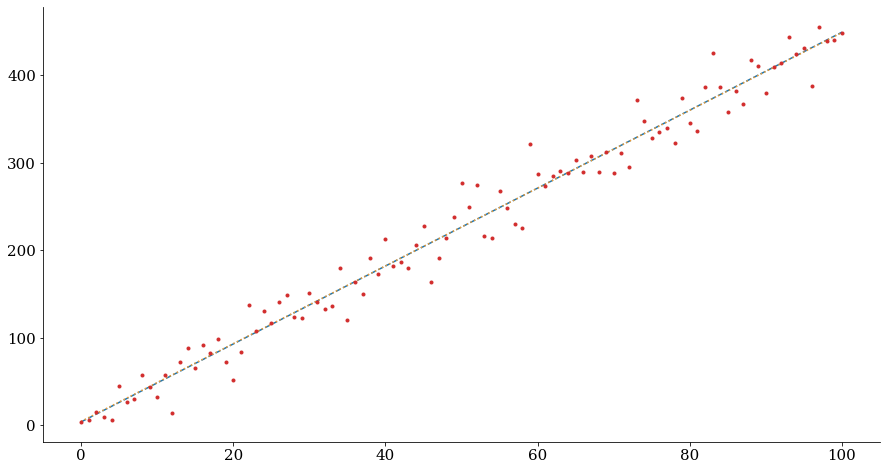

In [213]:
plt.plot(X, model_s.predict(X), ls = '--')
plt.plot(X, s_model.predict(X), ls = ':')
plt.plot(X, y_true, ls='', marker='.')

In [165]:
model_s.get_weights()

[array([[1.0898076]], dtype=float32),
 array([0.], dtype=float32),
 array([[-1.3974444]], dtype=float32),
 array([0.], dtype=float32)]